### Generative Adversarial Networks 

GAN is a type of generative model that operates on **Nash Equilibrium** concept derived from the field of **Game Theory**. On one hand we have the *Generator* Network that learns an input distribution and tries to generate realistic fakes that can fool its counterpart *Discriminator* Network. The *Discriminator* tries to correctly identify the real images and differentiate them from the fake images generated by the *Generator*.

We create a Vanilla GAN here, to understand its essential components.

In [1]:
# loading the packages
from IPython import display

# logger class from the utils python file -> source (giving full credits to diegoalejogm/gan)
# full interpretaion with comments added by me for better understanding
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# giving the path to data folder
DATA_FOLDER = './torch_data/VGAN/MNIST'

### Load Data

In [4]:
# using dataset from torchvision and composing transforms

# compose No transforms
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,), (.5,))])
    out_dir = '{}/dataset/notransforms'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# compose randomflips transform
def mnist_data_hflips():
    compose = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize((.5,), (.5,))])
    out_dir = '{}/dataset/Htransforms'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# compose randomflips transform
def mnist_data_vflips():
    compose = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize((.5,), (.5,))])
    out_dir = '{}/dataset/Vtransforms'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# compose randomflips transform
def mnist_data_flips():
    compose = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize((.5,), (.5,))])
    out_dir = '{}/dataset/HVtransforms'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [5]:
# defining some variables
BATCH_SIZE = 100
SHUFFLE = True

In [6]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# Num batches
num_batches = len(data_loader)

# Load data
data_hflips = mnist_data_hflips()
# Create loader with data, so that we can iterate over it
data_loader_hflips = torch.utils.data.DataLoader(data_hflips, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# Num batches
num_batches_hflips = len(data_loader_hflips)

# Load data
data_vflips = mnist_data_vflips()
# Create loader with data, so that we can iterate over it
data_loader_vflips = torch.utils.data.DataLoader(data_vflips, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# Num batches
num_batches_vflips = len(data_loader_vflips)

# Load data
data_flips = mnist_data_flips()
# Create loader with data, so that we can iterate over it
data_loader_flips = torch.utils.data.DataLoader(data_flips, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# Num batches
num_batches_flips = len(data_loader_flips)

### Network Development

Now, we develop the discriminator network and the generator network.

In [7]:
class DiscriminatorNet(torch.nn.Module):
    '''
    A Discriminator N/w with three hidden network, very simple
    '''
    def __init__(self):
        # extending from Module class of torch.nn
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer) and a dropout layer
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer) and a dropout layer
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer) and a dropout layer
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        # outer layer a linear layer with Sigmoid layer 
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    # forward propagation network
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

# three dimensions faced to two, one represents batch size and the other represents all the pixels 28 x 28    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

# function to conver 
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [8]:
class GeneratorNet(torch.nn.Module):
    """
    A Generator N/w with three hidden network, very simple
    """
    def __init__(self):
        # extending from Module class of torch.nn
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer) 
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer)
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer)
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        # hidden layer has one linear layer followed by a LeakyReLU (non linear layer)
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    # forward propagation network
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise used to feed the generator, size is the batch size
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [9]:
# creating instances of discriminator and generator
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

### Optimization

In [10]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

### Setting target values for real and fake data

Target values for real data is one and target value for fake data is zero.

In [11]:
# creating target values for real data
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    # this is if we could use GPU -> CUDA
    if torch.cuda.is_available(): 
        return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    # this is if we could use GPU -> CUDA
    if torch.cuda.is_available(): 
        return data.cuda()
    return data

### Training functions

In the training loop we see that only the discriminator network will be used. The generator network will be used to generate **fake data**.

In [12]:
# training function for discriminator network
def train_discriminator(optimizer, real_data, fake_data):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients, here the weights of discriminator will be optimized
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [13]:
# training function for generator network
def train_generator(optimizer, fake_data):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients, here the weights of generator will be optimized
    optimizer.step()
    
    # Return error
    return error

### Generate Samples for Testing

In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [15]:
test_noise

tensor([[-1.0221, -0.9727,  2.1790,  ...,  0.6675, -1.6672,  1.0620],
        [-0.3319, -0.0391, -0.6903,  ..., -0.2405, -0.0975,  1.2787],
        [-0.6302,  0.1216,  0.7927,  ..., -0.4988, -0.6162,  0.2594],
        ...,
        [-0.5803,  0.5584,  0.4538,  ..., -0.7449, -0.6140, -0.2471],
        [ 0.5873, -0.3957, -0.5085,  ...,  0.8743,  1.3536,  0.6744],
        [-1.6329,  0.6947,  1.7865,  ...,  0.4006,  0.8765, -2.5577]])

### Final Training Loop

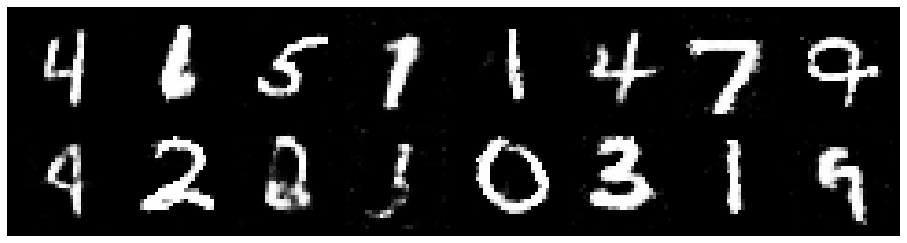

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.2723, Generator Loss: 0.8810
D(x): 0.5548, D(G(z)): 0.4577


In [16]:
# creating an instance of Logger class
logger = Logger(model_name='VGAN', data_name='MNIST')

# run each training epoch 
for epoch in range(num_epochs):
    
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        # Generate fake data, detach it since we don't want genewrator weights to change
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data)

        # Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(epoch, num_epochs, n_batch, num_batches,d_error, g_error, d_pred_real, d_pred_fake)
            
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)